In [1]:
import os
import pypsa
import pycountry
import pandas as pd
os.chdir("/home/user/Desktop/network_analysis")
import numpy as np
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
import re
warnings.filterwarnings("ignore")

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
path_2023 = "US_2023/networks/elec_s_10_ec_lcopt_Co2L-24H.nc"
path_2023_sec = "US_2023/postnetworks/elec_s_10_ec_lcopt_Co2L-24H_24H_2020_0.071_AB_10export.nc"

path_2030 = "US_2030/Medium/networks/elec_s_10_ec_lcopt_24H.nc"
path_2030_sec = "US_2030/Medium/postnetworks/elec_s_10_ec_lcopt_24H_24H_2030_0.071_AB_10export.nc"

path_2040 = "US_2040/Medium/networks/elec_s_10_ec_lcopt_24H.nc"
path_2040_sec = "US_2040/Medium/postnetworks/elec_s_100_ec_lcopt_24H_24H_2040_0.071_AB_10export.nc"

n_names = {
    "2023 power": path_2023,
    "2023 sector": path_2023_sec,
    "2030 power": path_2030,
    "2030 sector": path_2030_sec,
    "2040 power": path_2040,
    "2040 sector": path_2040_sec,
}

networks = {}
for name, path_i in n_names.items():
    networks[name] = pypsa.Network(path_i)

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-24H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-24H_24H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_24H.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_24H_24H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_24H.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_24H_24H_2040_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [3]:
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]
for name, n in networks.items():
    if "sector" not in name:
        continue

    nhours = n.snapshot_weightings.objective.sum()

    # 1. Look for all links related to target_processes
    process_links = n.links[n.links.carrier.isin(target_processes)]

    # 2. Filter AC input links
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index

    # 3. Sum AC consumption
    ac_industrial_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ac_industrial_twh = (ac_industrial_profile * n.snapshot_weightings.objective).sum() / 1e6

    print(f"{name} → Industrial AC: {ac_industrial_twh:.2f} TWh")

2023 sector → Industrial AC: 71.94 TWh
2030 sector → Industrial AC: 71.94 TWh
2040 sector → Industrial AC: 71.94 TWh


In [4]:
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]

static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV"]
demand = pd.DataFrame(columns=networks.keys(), index=dynamic_load_carriers+static_load_carriers+["total demand"])

for name, n in networks.items():
    if "sector" not in name:
        continue

    nhours = n.snapshot_weightings.objective.sum()

    # 1. Static loads (TWh)
    static_totals = (
        n.loads.groupby("carrier")
               .sum().p_set
               .reindex(static_load_carriers)
               .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    # 2. Separate industrial and non-industrial AC
    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index

    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # 3. Services & EV
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx   = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
                if i in n.loads_t.p_set.columns]

    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile   = n.loads_t.p_set[ev_idx].sum(axis=1)   if ev_idx else 0

    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh   = (ev_profile   * n.snapshot_weightings.objective).sum() / 1e6

    # 4. Industry electricity total = static + industrial AC
    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity",      name] = static_totals.get("agriculture electricity",  0) * nhours / 1e6
    demand.loc["industry electricity",         name] = industry_elec_twh
    demand.loc["AC",                           name] = ac_twh
    demand.loc["services electricity",         name] = serv_twh
    demand.loc["land transport EV",            name] = ev_twh
    demand.loc["total demand",                 name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh
    )


In [5]:
nrel_data = {
    "AC":                    [1360.81, 1359.91, 1392.19],
    "services electricity":  [1381.11, 1398.69, 1579.71],
    "land transport EV":     [13.10,   73.95,   59.70],
    "rail transport electricity": [7.29, 7.64, 8.29],
    "agriculture electricity": [0, 0, 0],
    "industry electricity":  [1036.81, 1109.69, 1213.94],
    "total demand": [3799.12, 4293.30, 5072.86],
}

In [6]:
import pandas as pd

years = ["2023", "2030", "2040"]
subcols = ["power", "sector", "NREL", "diff %"]

multi_cols = pd.MultiIndex.from_product([years, subcols])
new_demand = pd.DataFrame(index=demand.index, columns=multi_cols)

for i, year in enumerate(years):
    new_demand[(year, "power")]  = demand[f"{year} power"]
    new_demand[(year, "sector")] = demand[f"{year} sector"]

    for idx in demand.index:
        nrel_val = nrel_data.get(idx, [None] * 3)[i]
        new_demand.at[idx, (year, "NREL")] = nrel_val

        if nrel_val not in [None, 0]:
            sector_val = demand.at[idx, f"{year} sector"]
            new_demand.at[idx, (year, "diff %")] = 100 * (sector_val - nrel_val) / nrel_val
        else:
            new_demand.at[idx, (year, "diff %")] = None

new_demand = new_demand.round(2)

def highlight_diff(val):
    if pd.isna(val):
        return ''
    if val > 10:
        return 'background-color: #ffcccc'  # rosso chiaro
    elif val < -10:
        return 'background-color: #cce5ff'  # blu chiaro
    else:
        return 'background-color: #d4edda'  # verde chiaro

styled = new_demand.style

for year in years:
    styled = styled.applymap(highlight_diff, subset=pd.IndexSlice[:, (year, "diff %")])

for year in years[:-1]:
    styled = styled.set_properties(
        subset=pd.IndexSlice[:, (year, "diff %")],
        **{'border-right': '2px solid black'}
    )

styled


## Detailed electricity consumption per explicit industrial process

In [7]:
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]

for name, n in networks.items():
    if "sector" not in name:
        continue

    link_stats = n.statistics.energy_balance(comps=["Link"], aggregate_time="sum")
    df_filtered = link_stats[link_stats.index.get_level_values("carrier").isin(target_processes)]

    ac_input = {}

    for proc in target_processes:
        proc_df = df_filtered[df_filtered.index.get_level_values("carrier") == proc]
        inputs = proc_df[proc_df < 0].abs()
        input_row = inputs.groupby(level="bus_carrier").sum()
        ac_val = input_row.get("AC", 0)
        ac_input[proc] = ac_val / 1e6  # convert to TWh

    df_ac = pd.DataFrame.from_dict(ac_input, orient="index", columns=["AC input [TWh]"])
    df_ac = df_ac.sort_values(by="AC input [TWh]", ascending=False)

    print(f"\n⚡ AC electricity consumption – network: {name}")
    print(df_ac.round(2).to_string())



⚡ AC electricity consumption – network: 2023 sector
                        AC input [TWh]
EAF                              49.93
cement finishing                 24.54
Haber-Bosch                      22.01
dry clinker                       6.38
dry clinker CC                    0.06
SMR CC                            0.00
ethanol from starch CC            0.00
DRI CC                            0.00
ethanol from starch               0.00
DRI                               0.00
DRI H2                            0.00
BF-BOF                            0.00
BF-BOF CC                         0.00

⚡ AC electricity consumption – network: 2030 sector
                        AC input [TWh]
EAF                              49.93
cement finishing                 24.54
Haber-Bosch                      22.01
dry clinker                       6.06
dry clinker CC                    0.38
ethanol from starch CC            0.24
SMR CC                            0.00
DRI CC                            0.

## e-kerosene

In [8]:
for name, n in networks.items():
    if "sector" in name:
        kerosene_load = n.loads.query("carrier in 'kerosene for aviation'").p_set.sum()
        ekerosene_load = n.loads.query("carrier in 'e-kerosene for aviation'").p_set.sum()

n.loads.query("carrier in 'kerosene for aviation'").p_set.sum()

124987.75009956499

In [9]:
kerosene_load_all = {}

for name, n in networks.items():
    if "sector" in name:
        load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="sum")
        kerosene_load = load_stats[
            load_stats.index.get_level_values('carrier').str.contains('kerosene for aviation')
        ].sum()  # somma totale per kerosene
        ekerosene_load = load_stats[
            load_stats.index.get_level_values('carrier').str.contains('e-kerosene for aviation')
        ].sum()  # somma totale per e-kerosene

        kerosene_load_all[name] = {"kerosene": kerosene_load, "ekerosene": ekerosene_load}

# Stampa risultati
for name, stats in kerosene_load_all.items():
    print(f"{name} - Kerosene Load: {stats['kerosene']} GWh, e-Kerosene Load: {stats['ekerosene']} GWh")

2023 sector - Kerosene Load: -1003648060.7999861 GWh, e-Kerosene Load: 0.0 GWh
2030 sector - Kerosene Load: -1095140333.8306766 GWh, e-Kerosene Load: -7665982.336814741 GWh
2040 sector - Kerosene Load: -1190100750.9480321 GWh, e-Kerosene Load: -95208060.07584256 GWh


# Sector analysis

In [10]:
path_shape = "data/demand_data/gadm41_USA_1.json"
distance_code = "EPSG:3857"

In [11]:
carriers_of_interest = ['NH3', 'ethanol', 'DRI', 'steel BF-BOF', 'steel EAF', 'cement'] #'e-kerosene for aviation'

In [12]:
def attach_state_to_buses(network, path_shapes, distance_crs):
    """
    Attach state to buses
    """
    # Read the shapefile using geopandas
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)

    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query("carrier in @ac_dc_carriers")[["x", "y"]]

    network.buses["x"] = network.buses["location"].map(location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(location_mapping["y"]).fillna(0)
    
    pypsa_gpd = gpd.GeoDataFrame(
            network.buses, 
            geometry=gpd.points_from_xy(network.buses.x, network.buses.y), 
            crs=4326
        )

    bus_cols = network.buses.columns
    bus_cols = list(bus_cols) + ["State"]

    st_buses = gpd.sjoin_nearest(shapes, pypsa_gpd, how="right")[bus_cols]

    network.buses["state"] = st_buses["State"]

    return network

Processing network: 2023 sector


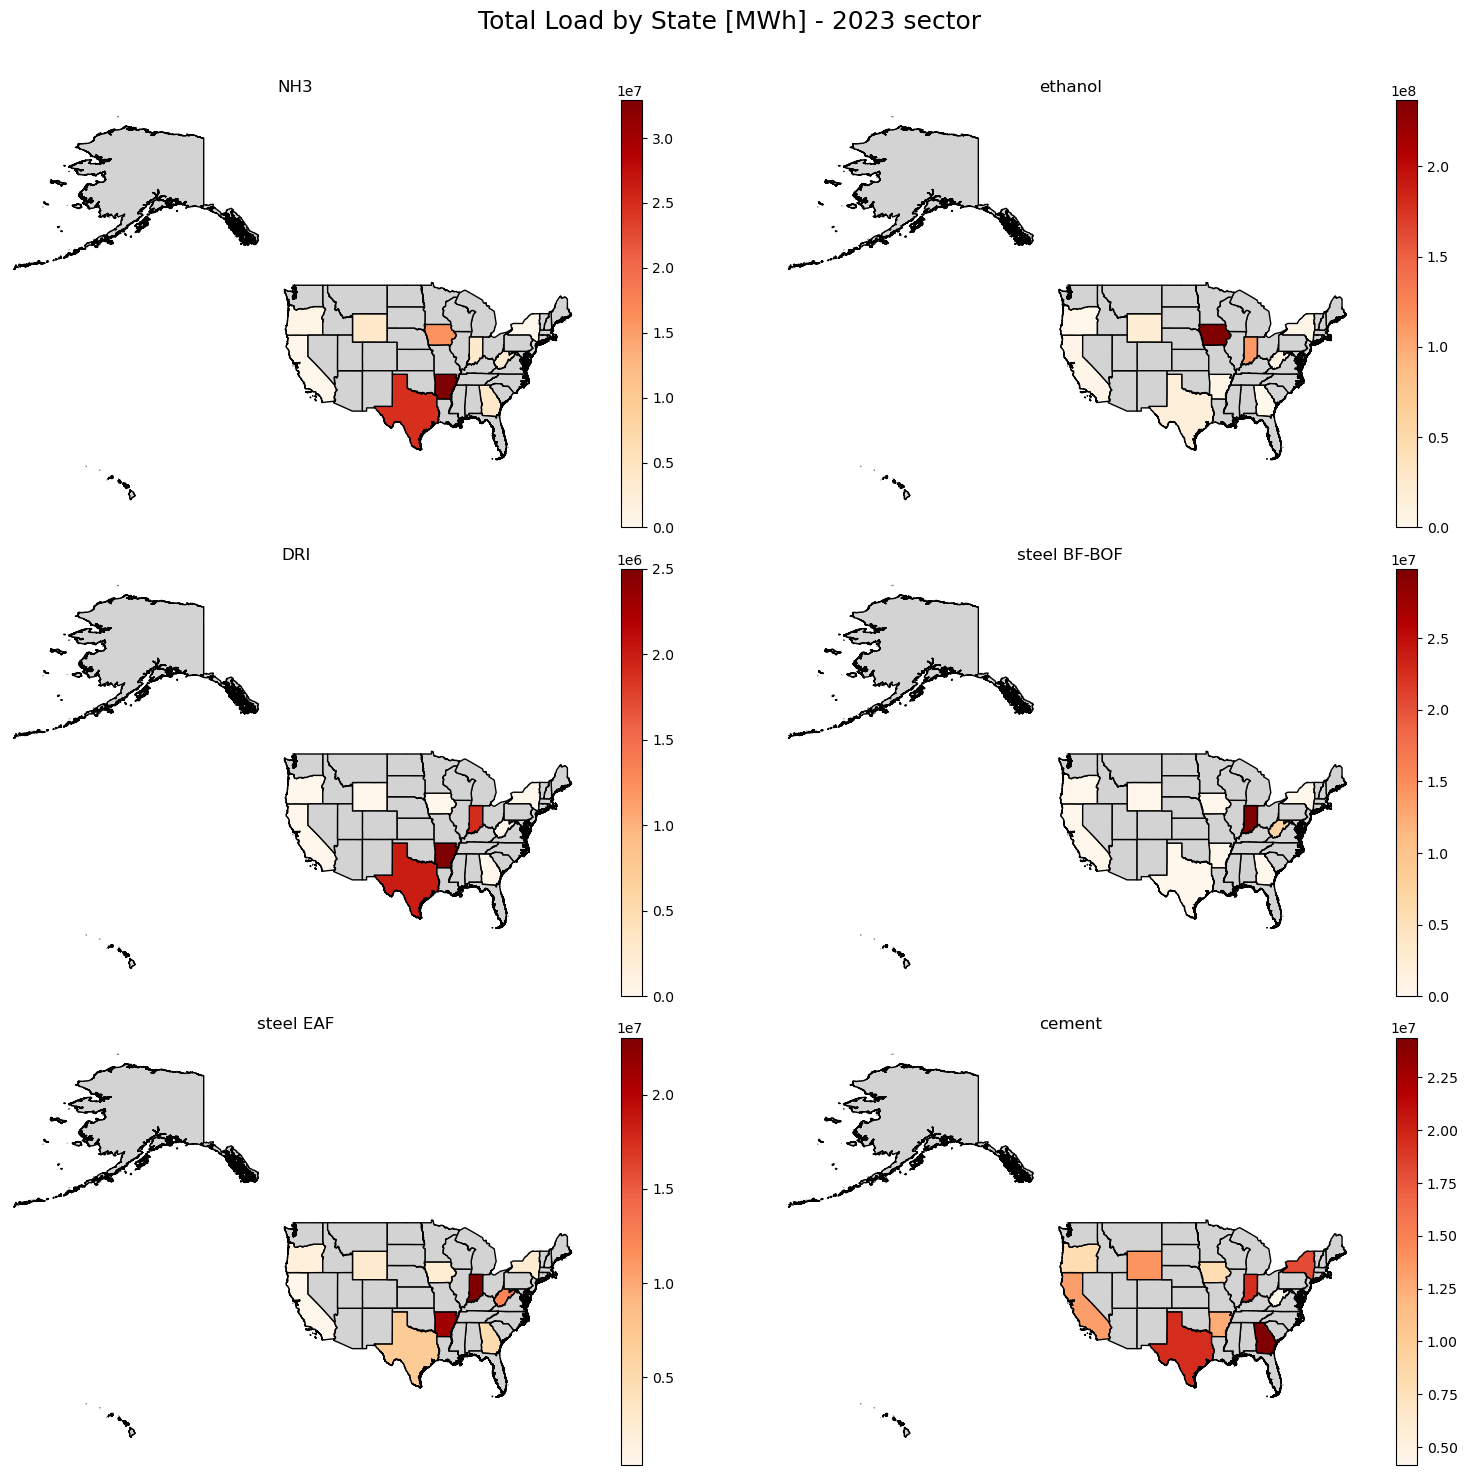

Processing network: 2030 sector


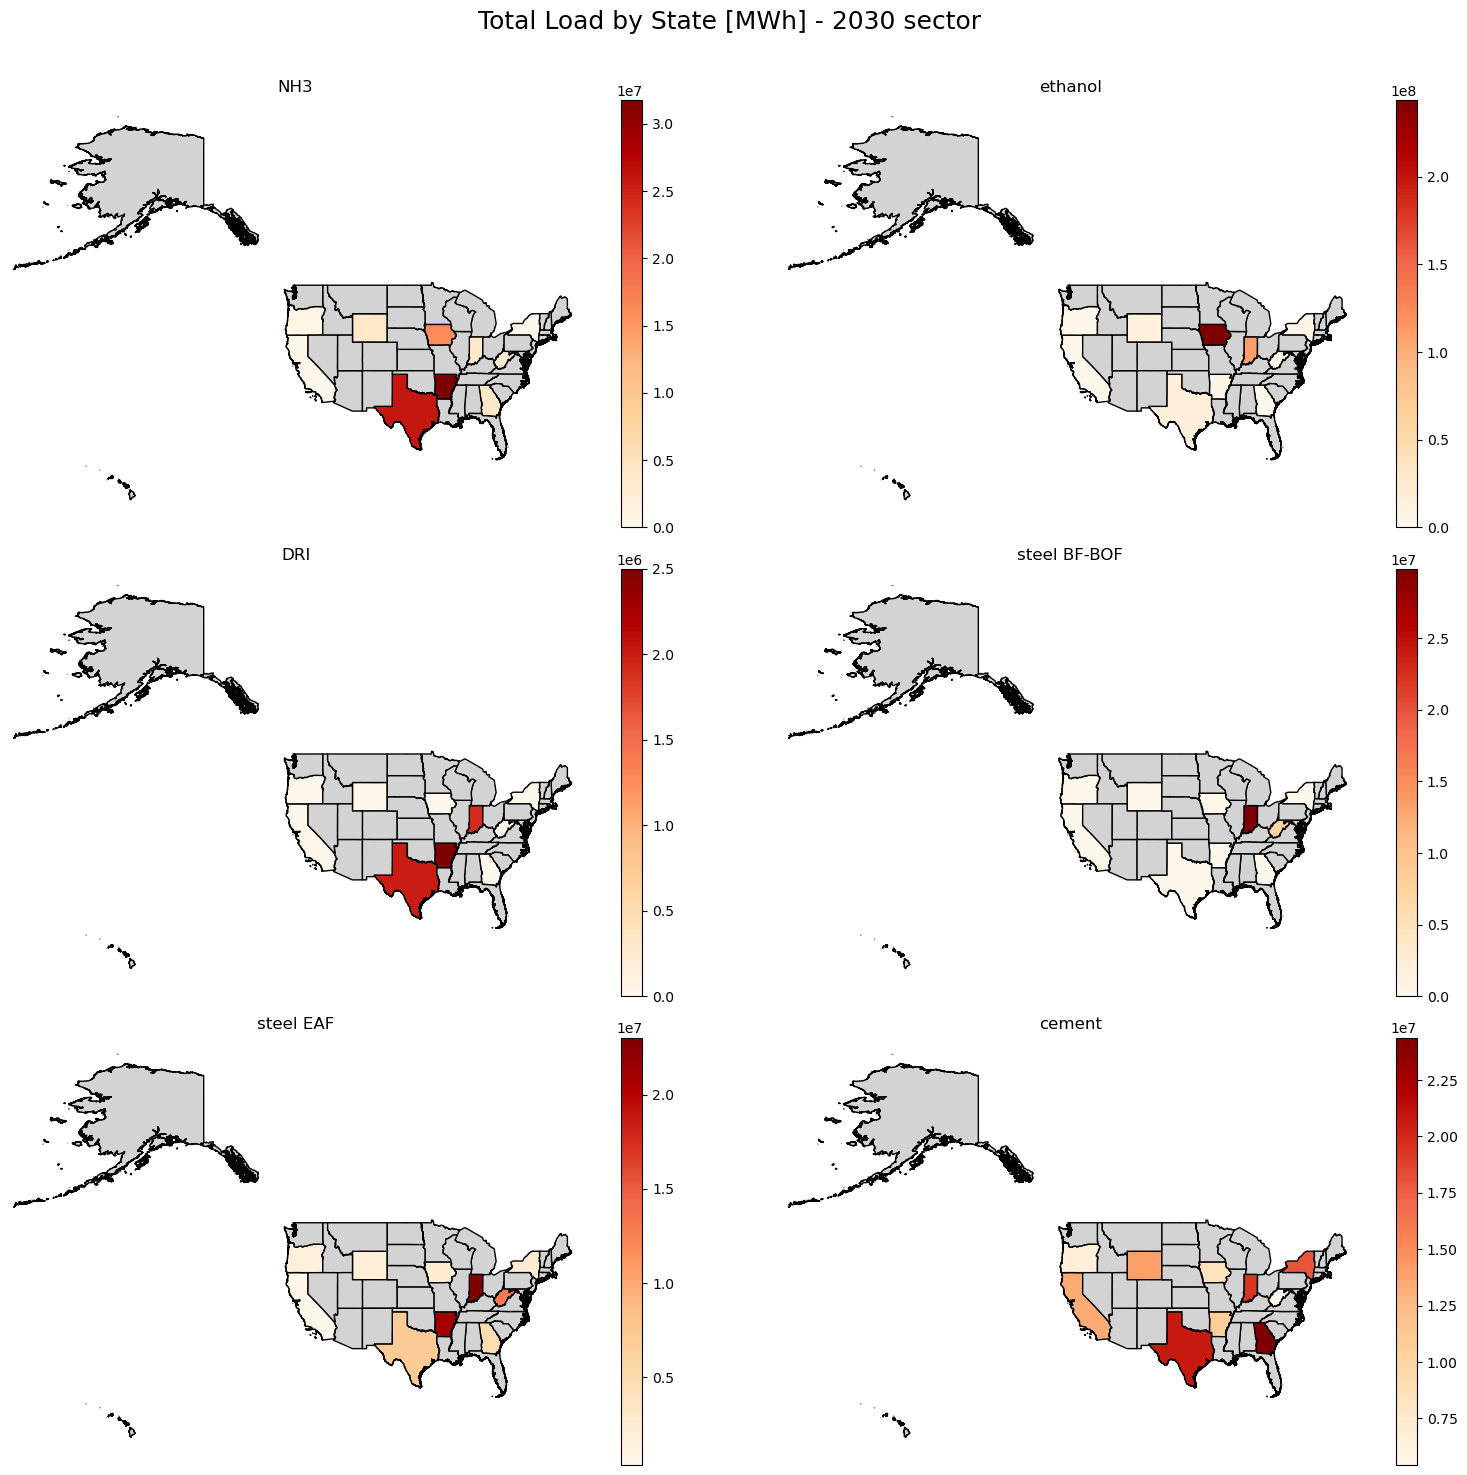

Processing network: 2040 sector


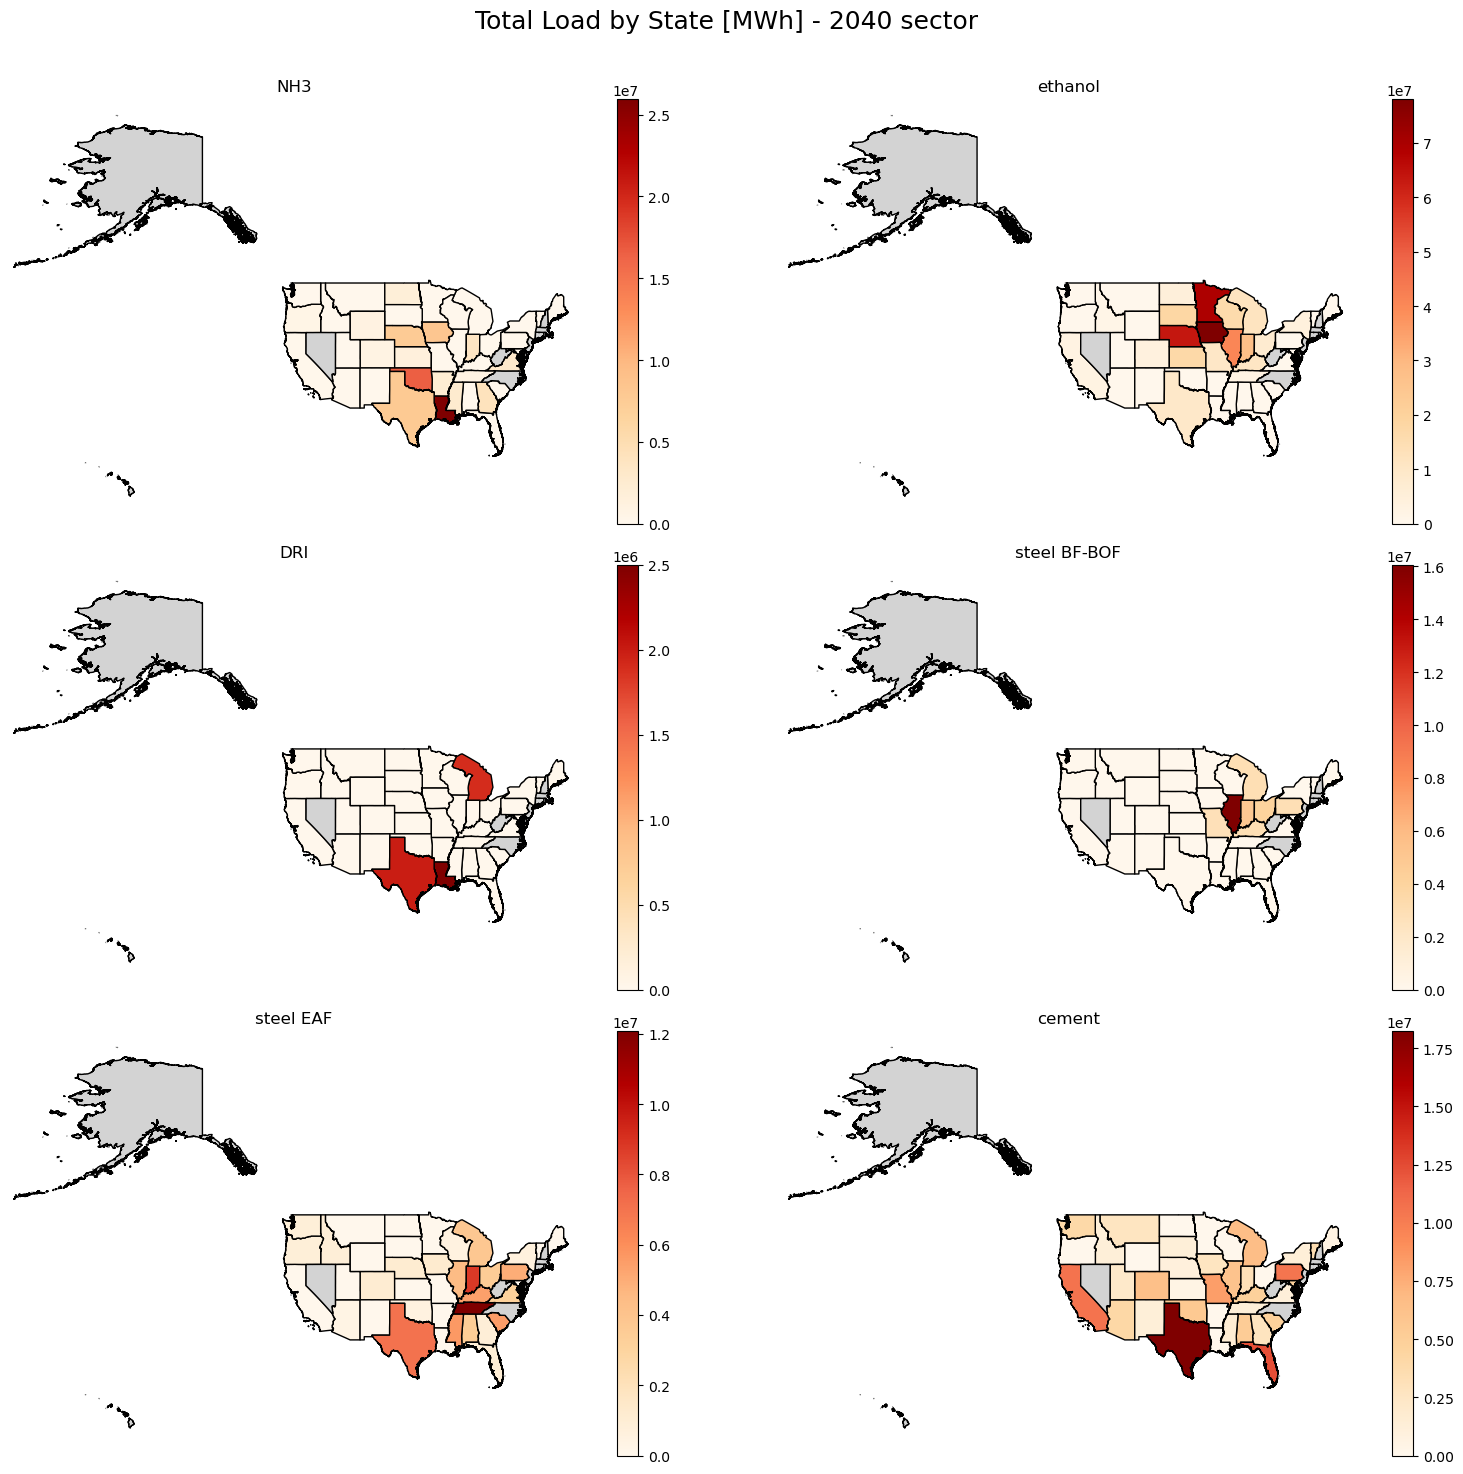

In [13]:
shapes = gpd.read_file(path_shape).to_crs("EPSG:4326")
shapes["state"] = shapes["ISO_1"].str[-2:]  # "US-CA" → "CA"

for name, net in networks.items():
    if "sector" not in name.lower():
        continue

    print(f"Processing network: {name}")

    # 1. Match States to bus
    net = attach_state_to_buses(net, path_shape, distance_code)

    # 2. Filter load per carrier
    filtered_loads = net.loads[net.loads["carrier"].isin(carriers_of_interest)].copy()

    # 3. Add State
    filtered_loads["state"] = filtered_loads["bus"].map(net.buses["state"])

    # 4. Aggregate
    load_by_state = (
        filtered_loads.groupby(["state", "carrier"])["p_set"]
        .sum()
        .mul(8760)  # MW → MWh
        .reset_index()
    )

    present_carriers = load_by_state["carrier"].unique().tolist()
    missing_carriers = [c for c in carriers_of_interest if c not in present_carriers]

    # Aggiungi empty rows for missing carriers to make plotting nicer
    for carrier in missing_carriers:
        load_by_state = pd.concat([
            load_by_state,
            pd.DataFrame({"state": shapes["state"], "carrier": carrier, "p_set": float("nan")})
        ], ignore_index=True)

    # Order by carriers_of_interest
    load_by_state["carrier"] = pd.Categorical(load_by_state["carrier"], categories=carriers_of_interest, ordered=True)
    load_by_state = load_by_state.sort_values("carrier")

    n_carriers = len(carriers_of_interest)
    n_cols = 2
    n_rows = (n_carriers + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 5))
    axes = axes.flatten()

    for i, carrier in enumerate(carriers_of_interest):
        carrier_data = load_by_state[load_by_state["carrier"] == carrier].copy()
        map_df = shapes.merge(carrier_data, on="state", how="left")

        ax = axes[i]
        map_df.plot(
            column="p_set",
            ax=ax,
            legend=True,
            cmap="OrRd",
            missing_kwds={"color": "lightgrey", "label": "No data"},
            edgecolor="black"
        )
        ax.set_title(f"{carrier}", fontsize=12)
        ax.set_xlim([-180, -65])
        ax.set_ylim([15,75])
        ax.axis('off')

        leg = ax.get_legend()
        if leg:
            leg.set_bbox_to_anchor((1, 0.5))
            for t in leg.get_texts():
                t.set_fontsize(8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Total Load by State [MWh] - {name}", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

## Emissions

In [14]:
# Specific conversion per carrier
conversion_factors = {
    "cement": (1 / 1000, "kt/a"),
    "DRI": (1 / 1000, "kt/a"),
    "steel BF-BOF": (1 / 1000, "kt/a"),
    "steel EAF": (1 / 1000, "kt/a"),
    "ethanol": (1/ 1000 / 5.1666, "kt/a"),  # 1 MWh = 5.1666 t
    "NH3": (1/ 80.2 * 3600 / 1e6, "Mgallon/a"),  # 1 MWh = 80.2 gallon
    # gli altri rimangono in MWh
}

summary_all = {}
units = {}

for name, network in networks.items():
    if "sector" not in name.lower():
        continue  

    network = attach_state_to_buses(network, path_shape, distance_code)

    filtered_loads = network.loads[network.loads["carrier"].isin(carriers_of_interest)].copy()

    filtered_loads["state"] = filtered_loads["bus"].map(network.buses["state"])

    summary = (
        filtered_loads.groupby("carrier")["p_set"]
        .sum()
        .mul(8760)  # converti da MW a MWh/a
        .reindex(carriers_of_interest)
        .fillna(0)
    )

    converted = []
    unit_column = []
    for carrier in carriers_of_interest:
        value = summary.get(carrier, 0)
        factor, unit = conversion_factors.get(carrier, (1, "MWh/a"))
        converted.append(round(value * factor, 2))
        unit_column.append(unit)

    summary_converted = pd.Series(converted, index=carriers_of_interest)
    summary_all[name] = summary_converted

    if "Unit" not in units:
        units["Unit"] = unit_column 

summary_df = pd.DataFrame(summary_all)
summary_df["Unit"] = units["Unit"]
summary_df.index.name = "Carrier"

pd.set_option('display.float_format', '{:,.2f}'.format)

print("Totale by carrier and network:")
print(summary_df.to_string())

Totale by carrier and network:
              2023 sector  2030 sector  2040 sector       Unit
Carrier                                                       
NH3              3,995.08     3,995.08     3,995.08  Mgallon/a
ethanol         77,660.06    77,660.06    77,660.06       kt/a
DRI              6,400.00     6,400.00     6,400.00       kt/a
steel BF-BOF    36,854.00    36,854.00    36,854.00       kt/a
steel EAF       78,072.39    78,072.39    78,072.39       kt/a
cement         141,374.68   141,374.68   141,374.68       kt/a


In [15]:
def compute_emissions_from_links(net):
    import pandas as pd
    import re

    results = []

    bus_cols = [col for col in net.links.columns if re.fullmatch(r"bus\d+", col)]

    for i, row in net.links.iterrows():
        carrier = row["carrier"]
        link_name = i
        co2_atmosphere = 0.0
        co2_stored = 0.0

        for j, bus_col in enumerate(bus_cols):
            bus_val = str(row[bus_col]).lower().strip()
            p_col = f"p{j}"

            if p_col not in net.links_t or link_name not in net.links_t[p_col]:
                continue

            flow = net.links_t[p_col][link_name].mean() * 8760  # MWh/year

            if "co2 atmosphere" in bus_val or "co2 atmoshpere" in bus_val:
                co2_atmosphere -= flow
            elif "co2 stored" in bus_val:
                co2_stored += flow

        results.append({
            "link": link_name,
            "carrier": carrier,
            "co2_atmosphere": co2_atmosphere,
            "co2_stored": co2_stored,
        })

    df = pd.DataFrame(results)
    df = df[(df["co2_atmosphere"] != 0) | (df["co2_stored"] != 0)]

    # Group per carrier and convert in Mt
    summary = df.groupby("carrier")[["co2_atmosphere", "co2_stored"]].sum().reset_index()
    summary["net_emissions"] = summary["co2_atmosphere"] - summary["co2_stored"]

    summary[["co2_atmosphere", "co2_stored", "net_emissions"]] = (
        summary[["co2_atmosphere", "co2_stored", "net_emissions"]] / 1e6
    ).round(2)

    summary = summary.rename(columns={
        "co2_atmosphere": "co2_atmosphere [Mt CO2]",
        "co2_stored": "co2_stored [Mt CO2]",
        "net_emissions": "net_emissions [Mt CO2]"
    })

    return summary

In [16]:
for name, net in networks.items():
    if "sector" not in name:
        continue

    print(f"\n=== {name} ===")

    df = compute_emissions_from_links(net)

    # Filter rows with emissions != 0 only
    df_nonzero = df[
        (df["co2_atmosphere [Mt CO2]"] != 0) |
        (df["co2_stored [Mt CO2]"] != 0) |
        (df["net_emissions [Mt CO2]"] != 0)
    ]

    if df_nonzero.empty:
        print("No relevant emissions.")
    else:
        print(df_nonzero.to_string(index=False))



=== 2023 sector ===
                           carrier  co2_atmosphere [Mt CO2]  co2_stored [Mt CO2]  net_emissions [Mt CO2]
                            BF-BOF                    17.71                 0.00                   17.71
                               DRI                     3.52                 0.00                    3.52
                   Fischer-Tropsch                     0.00               289.60                 -289.60
                     biogas to gas                    -0.10                 0.00                   -0.10
                  gas for industry                   295.78                 0.00                  295.78
                           helmeth                     0.00               811.76                 -811.76
              process emissions CC                    40.06              -360.58                  400.64
     solid biomass for industry CC                  -141.24              -141.24                    0.00
urban central solid biomass CHP CC

In [17]:
def compute_emissions_grouped(net, carrier_groups):
    import pandas as pd
    import re

    results = []

    bus_cols = [col for col in net.links.columns if re.fullmatch(r"bus\d+", col)]

    for i, row in net.links.iterrows():
        carrier = row["carrier"]
        link_name = i
        co2_atmosphere = 0.0
        co2_stored = 0.0

        for j, bus_col in enumerate(bus_cols):
            bus_val = str(row[bus_col]).lower().strip()
            p_col = f"p{j}"

            if p_col not in net.links_t or link_name not in net.links_t[p_col]:
                continue

            flow = net.links_t[p_col][link_name].mean() * 8760  # MWh/year

            if "co2 atmosphere" in bus_val or "co2 atmoshpere" in bus_val:
                co2_atmosphere -= flow
            elif "co2 stored" in bus_val:
                co2_stored += flow

        results.append({
            "link": link_name,
            "carrier": carrier,
            "co2_atmosphere": co2_atmosphere,
            "co2_stored": co2_stored,
        })

    df = pd.DataFrame(results)

    all_grouped_carriers = set(sum(carrier_groups.values(), []))
    df = df[df["carrier"].isin(all_grouped_carriers)]

    carrier_summary = df.groupby("carrier")[["co2_atmosphere", "co2_stored"]].sum().reset_index()

    group_results = []
    for group_name, group_carriers in carrier_groups.items():
        group_df = carrier_summary[carrier_summary["carrier"].isin(group_carriers)]
        co2_atm = group_df["co2_atmosphere"].sum()
        co2_stored = group_df["co2_stored"].sum()
        net_emissions = co2_atm - co2_stored

        group_results.append({
            "carrier_group": group_name,
            "co2_atmosphere [Mt CO2]": round(co2_atm / 1e6, 2),
            "co2_stored [Mt CO2]": round(co2_stored / 1e6, 2),
            "net_emissions [Mt CO2]": round(net_emissions / 1e6, 2)
        })

    return pd.DataFrame(group_results)


In [18]:
carrier_groups = {
    "BF-BOF": ["BF-BOF", "BF-BOF CC"],
    "DRI": ["DRI", "DRI CC"],
    "ethanol from starch": ["ethanol from starch", "ethanol from starch CC"],
    "SMR": ["SMR", "SMR CC"],
    "dry clinker": ["dry clinker", "dry clinker CC"]
}

for name, net in networks.items():
    if "sector" not in name.lower():
        continue

    print(f"\n=== {name} ===")

    df_summary = compute_emissions_grouped(net, carrier_groups)

    df_filtered = df_summary[
        (df_summary[["co2_atmosphere [Mt CO2]", "co2_stored [Mt CO2]", "net_emissions [Mt CO2]"]]
         .abs().sum(axis=1) > 0)
    ]

    print(df_filtered.to_string(index=False))




=== 2023 sector ===
carrier_group  co2_atmosphere [Mt CO2]  co2_stored [Mt CO2]  net_emissions [Mt CO2]
       BF-BOF                    17.71                -0.00                   17.71
          DRI                     3.52                -0.00                    3.52

=== 2030 sector ===
      carrier_group  co2_atmosphere [Mt CO2]  co2_stored [Mt CO2]  net_emissions [Mt CO2]
             BF-BOF                    17.71                -0.00                   17.71
                DRI                     3.52                -0.00                    3.52
ethanol from starch                     0.00                -1.97                    1.97
                SMR                    32.08                -0.01                   32.09

=== 2040 sector ===
      carrier_group  co2_atmosphere [Mt CO2]  co2_stored [Mt CO2]  net_emissions [Mt CO2]
             BF-BOF                    17.71                -0.00                   17.71
                DRI                     3.52           

In [19]:
def compute_emissions_by_state(net, carrier_groups):

    results = []

    bus_cols = [col for col in net.links.columns if re.fullmatch(r"bus\d+", col)]

    for i, row in net.links.iterrows():
        carrier = row["carrier"]
        link_name = i
        co2_atmos = 0.0
        co2_stored = 0.0

        group = next((g for g, carriers in carrier_groups.items() if carrier in carriers), None)
        if group is None:
            continue

        for j, bus_col in enumerate(bus_cols):
            bus_val = str(row[bus_col]).lower().strip()
            p_col = f"p{j}"

            if p_col not in net.links_t or link_name not in net.links_t[p_col]:
                continue

            flow = net.links_t[p_col][link_name].mean() * 8760  # Mt CO2/year

            if "co2 atmosphere" in bus_val or "co2 atmoshpere" in bus_val:
                co2_atmos -= flow
            elif "co2 stored" in bus_val:
                co2_stored += flow

        state = "Unknown"
        for bus_col in bus_cols:
            bus = row[bus_col]
            if bus in net.buses.index:
                s = net.buses.loc[bus, "state"]
                if pd.notna(s) and s != "Unknown":
                    state = s
                    break

        results.append({
            "state": state,
            "group": group,
            "co2_atmosphere": co2_atmos,
            "co2_stored": co2_stored
        })

    df = pd.DataFrame(results)

    summary = df.groupby(["state", "group"])[["co2_atmosphere", "co2_stored"]].sum().reset_index()
    summary["net_emissions"] = summary["co2_atmosphere"] - summary["co2_stored"]

    summary[["co2_atmosphere", "co2_stored", "net_emissions"]] = (
        summary[["co2_atmosphere", "co2_stored", "net_emissions"]] / 1e6 # Convert to MtCO2
    ).round(2)

    return summary


In [20]:
def plot_emissions_maps_by_group(all_state_emissions, path_shapes, distance_crs, title):

    # Upload shapefile and force CRS
    gdf_states = gpd.read_file(path_shapes).to_crs("EPSG:4326")
    gdf_states["State"] = gdf_states["ISO_1"].str[-2:]

    groups = all_state_emissions["group"].unique()
    n = len(groups)
    ncols = 2
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * nrows))
    axes = axes.flat if n > 1 else [axes]

    for i, group in enumerate(groups):
        ax = axes[i]
        df_group = all_state_emissions[all_state_emissions["group"] == group].copy()
        df_group = df_group.rename(columns={"State": "State"})

        merged = gdf_states.merge(df_group, on="State", how="left")
        
        merged.plot(
            column="net_emissions",
            cmap="Reds",
            legend=True,
            ax=ax,
            missing_kwds={"color": "lightgrey", "label": "No data"},
            edgecolor="black"
        )
        
        ax.set_title(f"{group}", fontsize=12)
        ax.set_xlim([-180, -65])
        ax.set_ylim([15, 75])
        ax.axis("off")

        leg = ax.get_legend()
        if leg:
            leg.set_bbox_to_anchor((1, 0.5))
            for t in leg.get_texts():
                t.set_fontsize(8)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Net Emissions by process and State [MtCO2/yr] - {title}", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [21]:
gdf_states = gpd.read_file(path_shape)
gdf_states = gdf_states.to_crs("EPSG:4326") 

for name, net in networks.items():
    if "sector" not in name.lower():
        continue

    print(f"\n=== {name} ===")

    df_state_emissions = compute_emissions_by_state(net, carrier_groups)

    df_filtered = df_filtered.rename(columns={"state": "State"})

    print(df_filtered.rename(columns={
        "co2_atmosphere": "CO2 to Atmosphere [MtCO2/yr]",
        "co2_stored": "CO2 Stored [MtCO2/yr]",
        "net_emissions": "Net Emissions [MtCO2/yr]"
    }).to_string(index=False))


=== 2023 sector ===
      carrier_group  co2_atmosphere [Mt CO2]  co2_stored [Mt CO2]  net_emissions [Mt CO2]
             BF-BOF                    17.71                -0.00                   17.71
                DRI                     3.52                -0.00                    3.52
ethanol from starch                     0.00               -24.47                   24.47
                SMR                    64.67                -0.00                   64.67

=== 2030 sector ===
      carrier_group  co2_atmosphere [Mt CO2]  co2_stored [Mt CO2]  net_emissions [Mt CO2]
             BF-BOF                    17.71                -0.00                   17.71
                DRI                     3.52                -0.00                    3.52
ethanol from starch                     0.00               -24.47                   24.47
                SMR                    64.67                -0.00                   64.67

=== 2040 sector ===
      carrier_group  co2_atmosphere [


=== 2023 sector ===


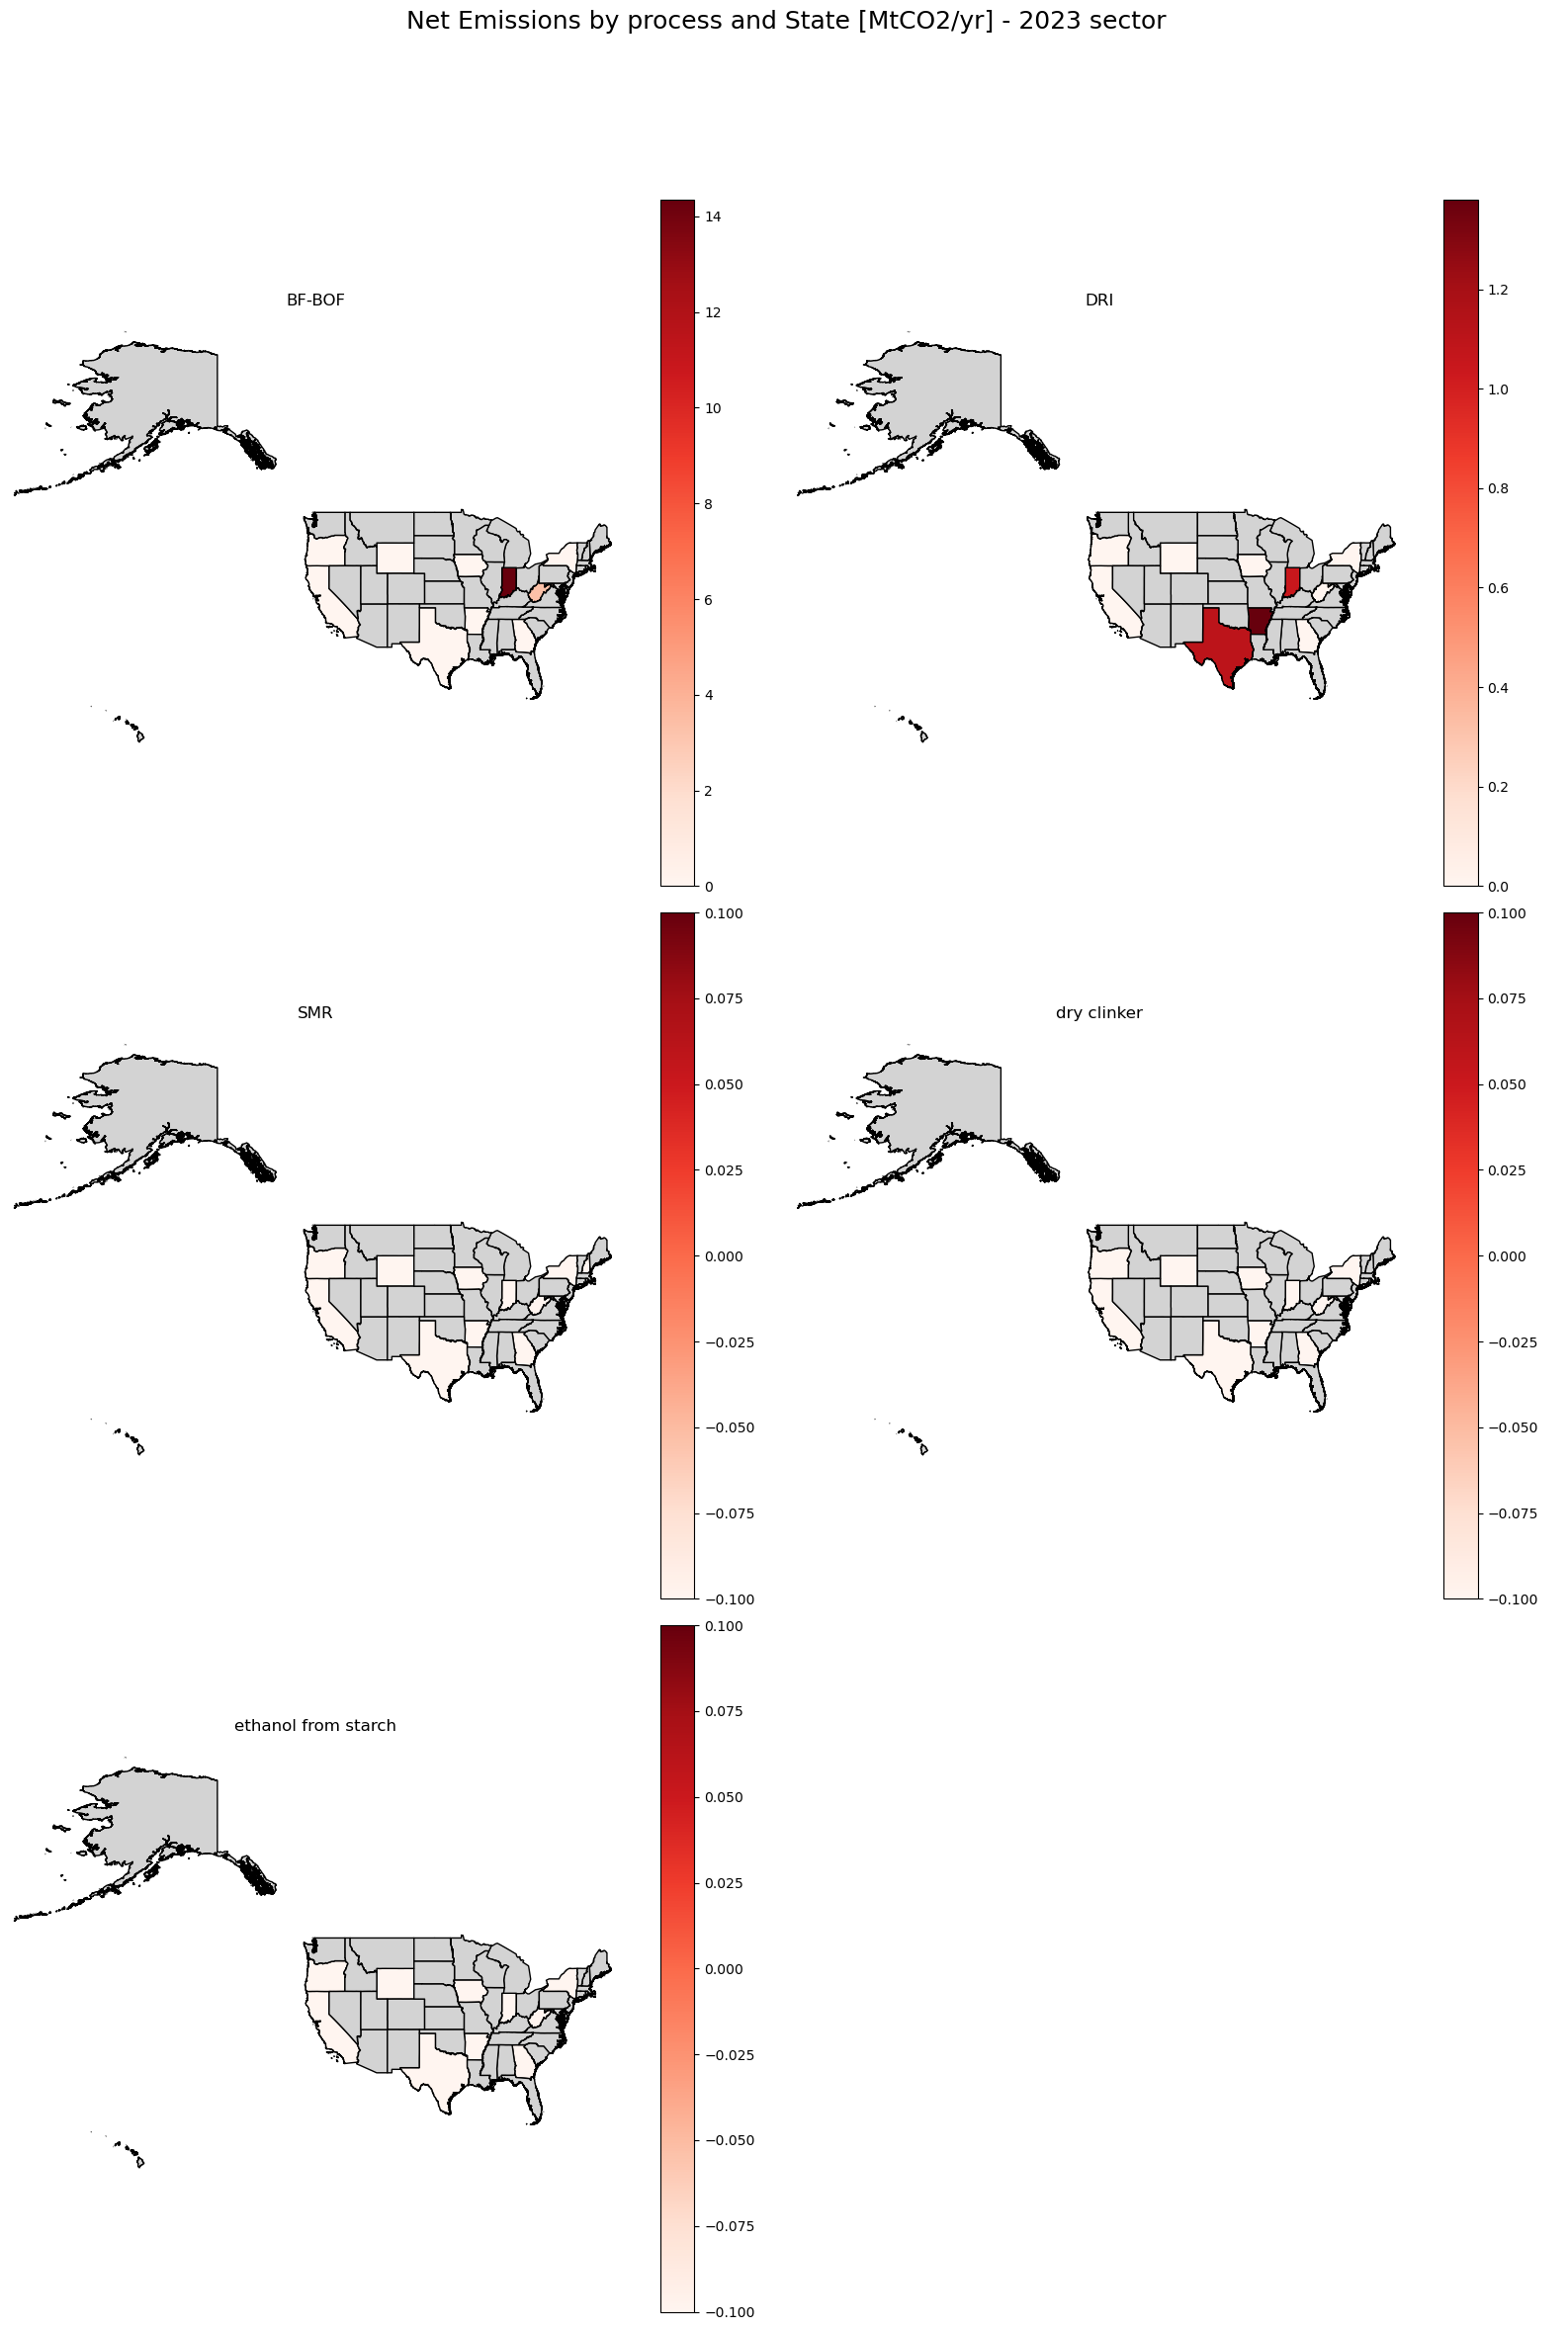


=== 2030 sector ===


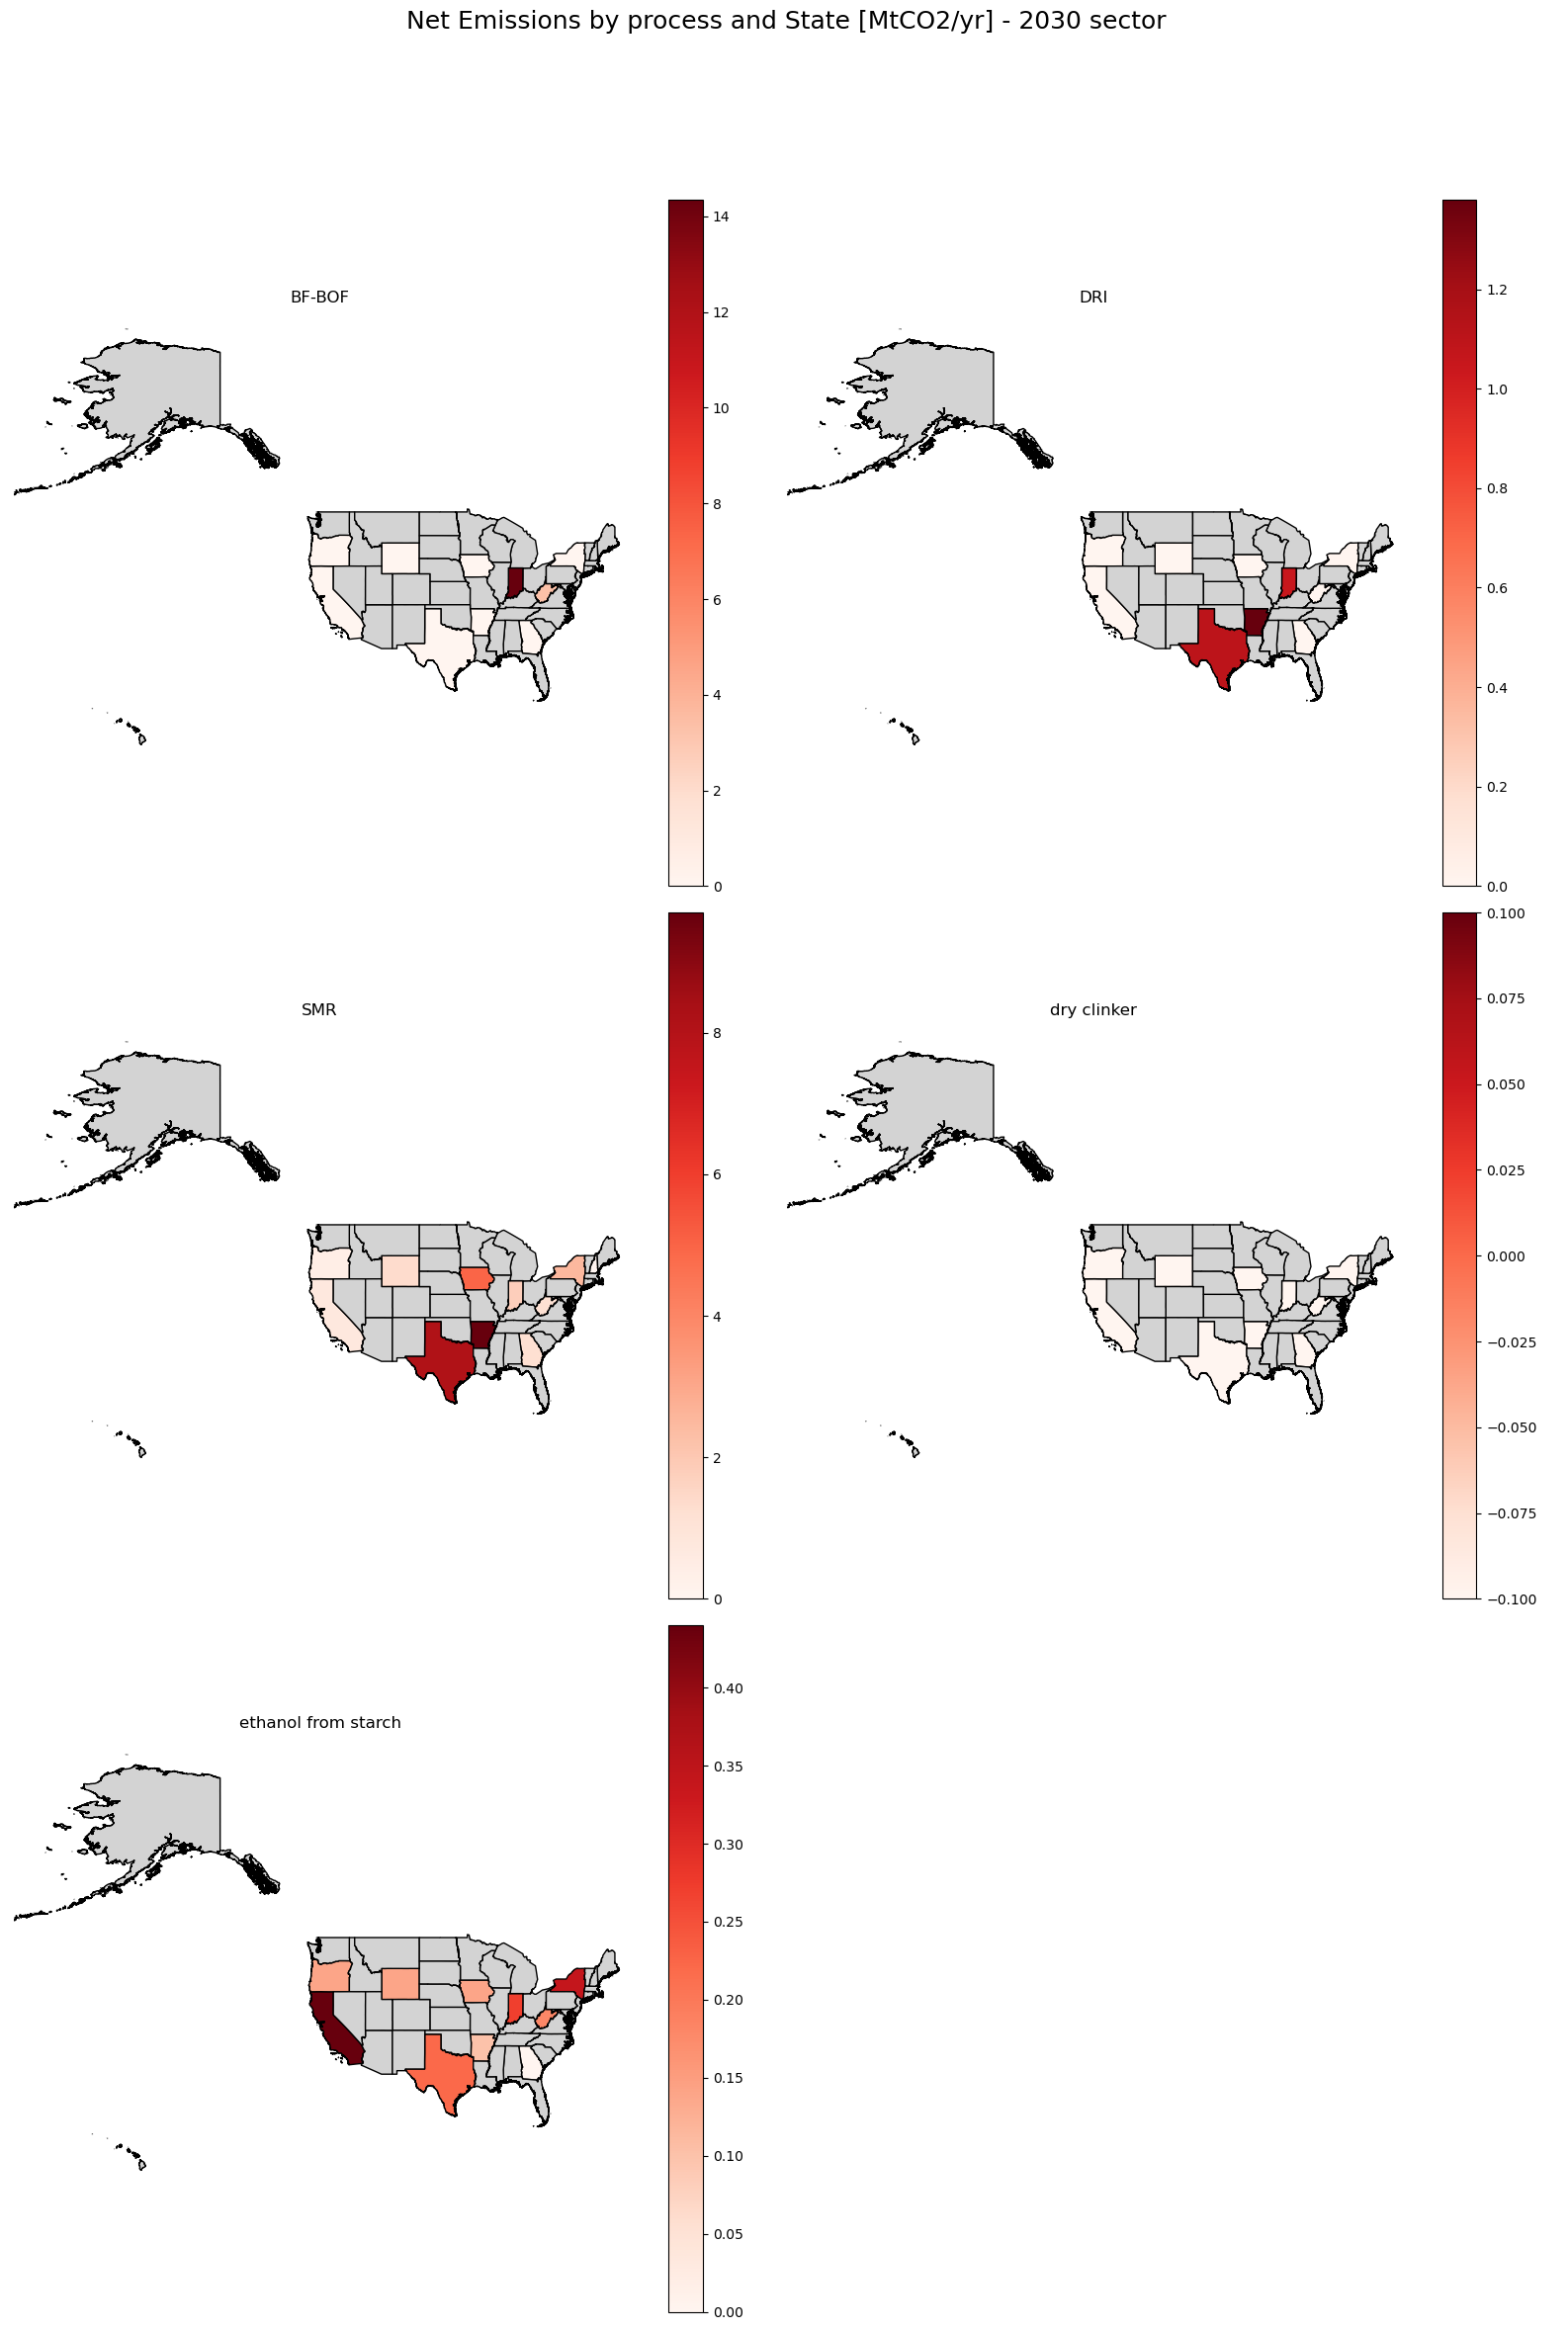


=== 2040 sector ===


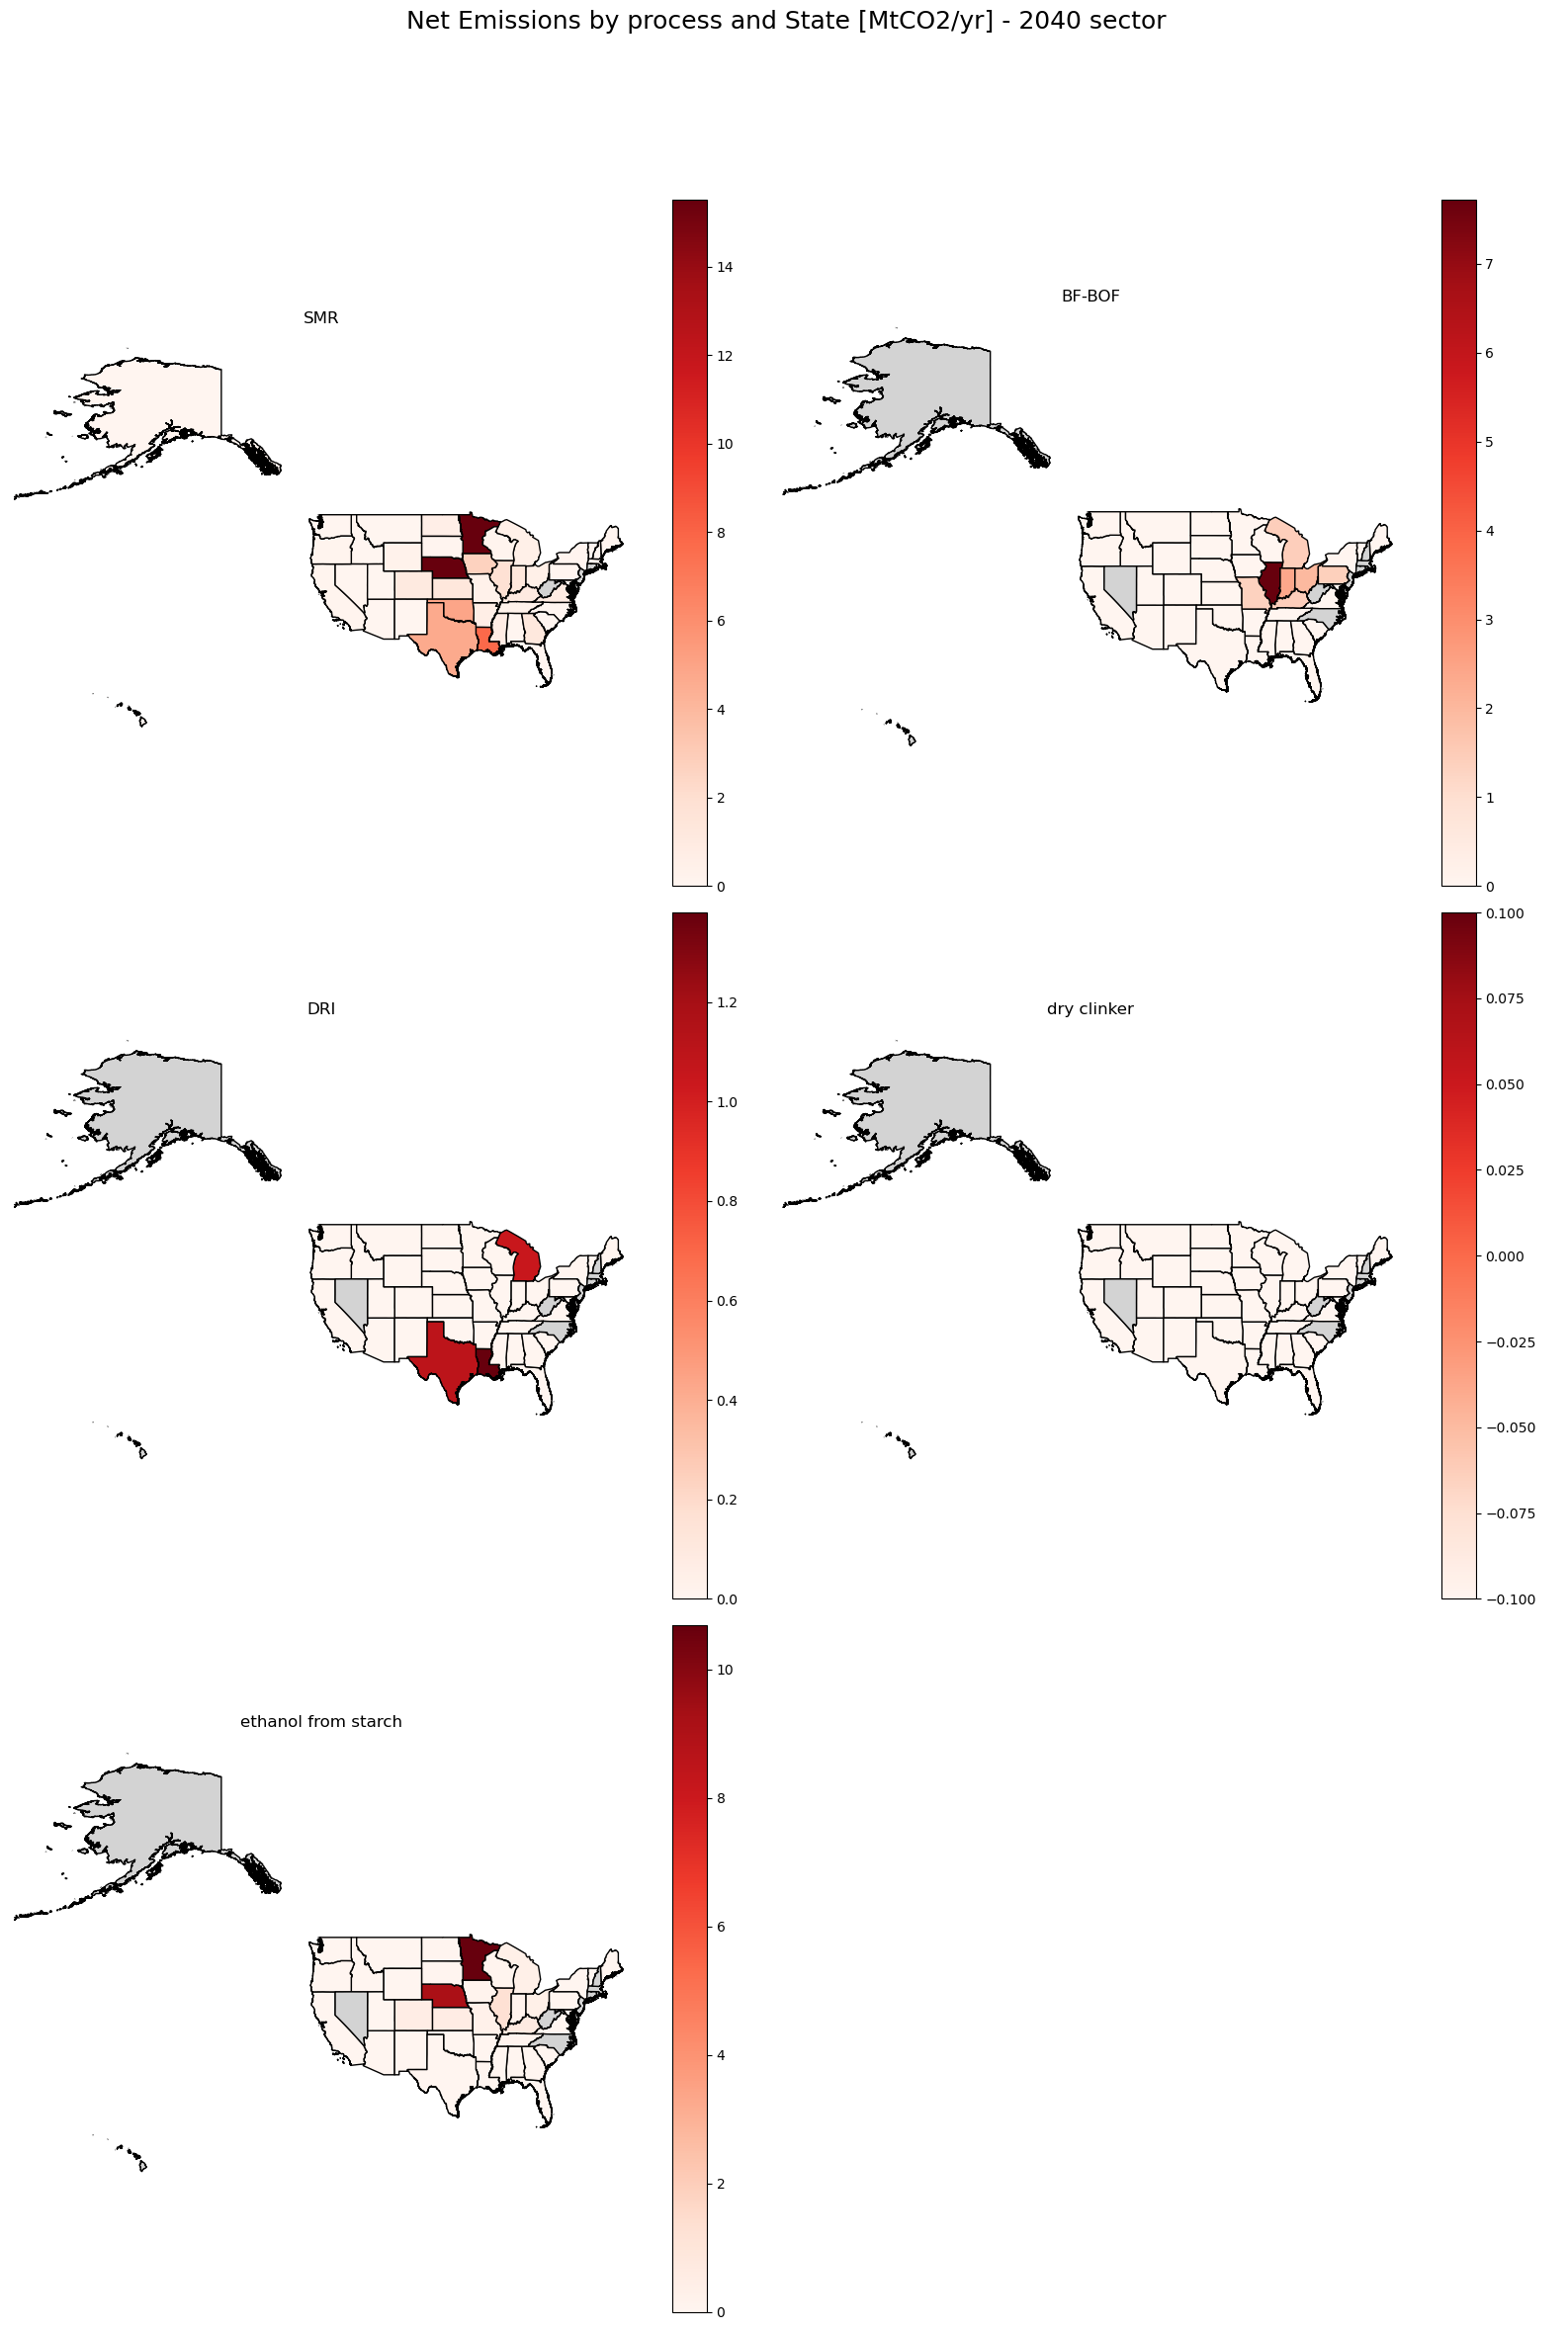

In [22]:
for name, net in networks.items():
    if "sector" not in name.lower():
        continue

    print(f"\n=== {name} ===")

    df_state_emissions = compute_emissions_by_state(net, carrier_groups)
    df_filtered = df_state_emissions.rename(columns={"state": "State"})

    plot_emissions_maps_by_group(df_filtered, path_shape, distance_code, name)